In [1]:
%pylab inline
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
import cartopy
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import math as math
from ParticlePlotFunctions import *
import matplotlib.animation as animation
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load bathymetry

latdim = np.arange(1000,2001)
londim = np.arange(2000,3001)
bathy_file = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/domain/bathymetry_ORCA12_V3.3.nc'
dfile = Dataset(bathy_file)
bathy = dfile.variables['Bathymetry'][latdim,londim]
lat = dfile.variables['nav_lat'][latdim,londim]
lon = dfile.variables['nav_lon'][latdim,londim]
bathy = np.where(bathy<1, nan, bathy)

In [3]:
#load particle data

namefile = '../../data/galapagosparticles_bwd_v2.nc'
Traj = ReadTrajectories(namefile)

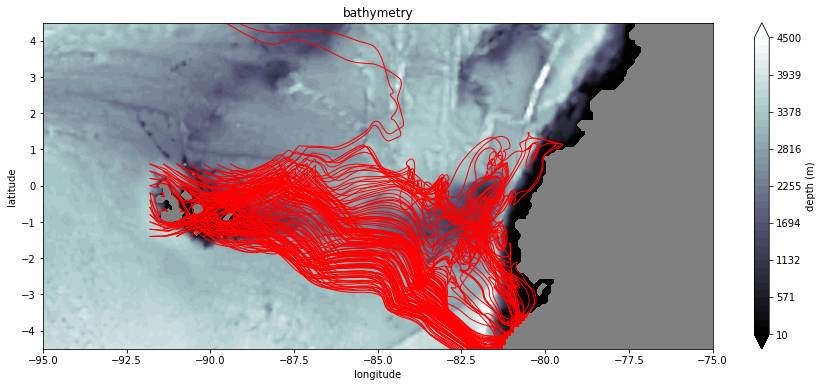

In [25]:
#quick check output

plat = Traj['lat'][0:300:2,0:200]
plon = Traj['lon'][0:300:2,0:200]
map_extent = [-95,-75,-4.5,4.5]
figsize=(15,6)
PlotBathyTraj(plon,plat,lon,lat,bathy,figsize,map_extent)

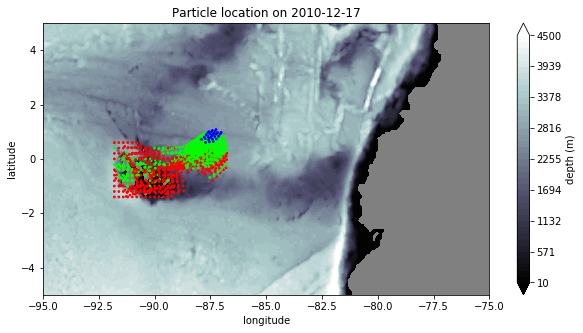

In [32]:
# Make a movie (works for both forward and backward)

map_extent = [-95,-75,-5,5]
pylab.rcParams['figure.figsize'] = (10, 5)
Zmin = 10
Zmax = 4500

plat = Traj['lat'][0:300,0:200]
plon = Traj['lon'][0:300,0:200]
ptime= Traj['time'][0:300,0:200]
plottimes = np.arange(np.min(ptime), np.max(ptime), dtype='datetime64[5D]')

# where is particle coming from
pdirection = np.zeros([plat.shape[0],3], dtype=int) #from where is particle coming
pdirection[:] = [0,1,0]
for p in range(plat.shape[0]):                      
    if np.any(plat[p,:] > 4.5) and not np.any(plat[p,:] < -4.5):          
        pdirection[p,:] = [0,0,1]
    if np.any(plat[p,:] < -4.5) and not np.any(plat[p,:] > 4.5):
        pdirection[p,:] = [1,0,0]
    if np.any(plat[p,:] < -4.5) and np.any(plat[p,:] > 4.5):
        latmax = np.where(plat[p,:] > 4.5)[0][0]    
        latmin = np.where(plat[p,:] < -4.5)[0][0]
        if latmax < latmin:
            pdirection[p,:] = [0,0,1]
        else:
            pdirection[p,:] = [1,0,0]

fig, ax = plt.subplots(1,1)

levels = np.linspace(Zmin, Zmax, 41)
fig1 = ax.contourf(lon,lat,bathy,       
                      levels = levels,    
                      cmap='bone',       
                      extend='both',      
                      origin='lower')              
ax.set_xlabel('longitude')                 
ax.set_ylabel('latitude') 
ax.set_xlim(map_extent[0:2])
ax.set_ylim(map_extent[2:4])
ax.set_facecolor('gray')
cbar = plt.colorbar(fig1, ax=ax)
cbar.ax.set_ylabel('depth (m)')

t=0
b = np.where(np.logical_and(ptime >= plottimes[t], ptime < plottimes[t+1]))
scat = ax.scatter(plon[b], plat[b], s=3, c=pdirection[b[0],:])
ttl = ax.set_title('Particle location on ' + str(plottimes[0]))
frames = np.arange(0, len(plottimes)-1)

def animate(t):
    b = np.where(np.logical_and(ptime >= plottimes[t], ptime < plottimes[t+1]))
    scat.set_offsets(np.vstack((plon[b], plat[b])).transpose())
    particle_color = pdirection[b[0],:]
    scat.set_color(particle_color)
    ttl.set_text('Particle location on ' + str(plottimes[t]))
    return scat,

ax.set_xlim(map_extent[0:2])
ax.set_ylim(map_extent[2:4])

anim = animation.FuncAnimation(fig, animate, frames=frames, interval=100, blit=True)
anim
anim.save('../../results/figures/galapagosparticles_south_vs_north.gif', writer='imagemagick', fps=10)

In [31]:
a = np.zeros([6,3])
a[:] = [0,1,0]

print(a)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


/home/sypmauu/.conda/envs/py3_parcels/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  if sys.path[0] == '':


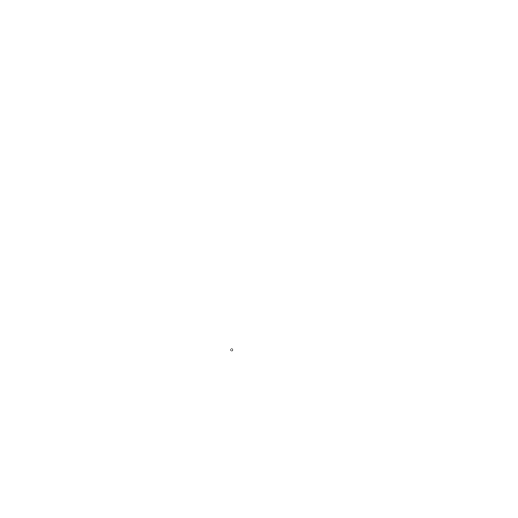

In [12]:
# Create new Figure and an Axes which fills it.
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(0,1), ax.set_xticks([])
ax.set_ylim(0,1), ax.set_yticks([])

# Create rain data
n_drops = 50
rain_drops = np.zeros(n_drops, dtype=[('position', float, 2),
                                      ('size',     float, 1),
                                      ('growth',   float, 1),
                                      ('color',    float, 4)])

# Initialize the raindrops in random positions and with
# random growth rates.
rain_drops['position'] = np.random.uniform(0, 1, (n_drops, 2))
rain_drops['growth'] = np.random.uniform(50, 200, n_drops)

# Construct the scatter which we will update during animation
# as the raindrops develop.
scat = ax.scatter(rain_drops['position'][:,0], rain_drops['position'][:,1],
                  s=rain_drops['size'], lw=0.5, edgecolors=rain_drops['color'],
                  facecolors='none')


def update(frame_number):
    # Get an index which we can use to re-spawn the oldest raindrop.
    current_index = frame_number % n_drops

    # Make all colors more transparent as time progresses.
    rain_drops['color'][:, 3] -= 1.0/len(rain_drops)
    rain_drops['color'][:,3] = np.clip(rain_drops['color'][:,3], 0, 1)

    # Make all circles bigger.
    rain_drops['size'] += rain_drops['growth']

    # Pick a new position for oldest rain drop, resetting its size,
    # color and growth factor.
    rain_drops['position'][current_index] = np.random.uniform(0, 1, 2)
    rain_drops['size'][current_index] = 5
    rain_drops['color'][current_index] = (0, 0, 0, 1)
    rain_drops['growth'][current_index] = np.random.uniform(50, 200)

    # Update the scatter collection, with the new colors, sizes and positions.
    scat.set_edgecolors(rain_drops['color'])
    scat.set_sizes(rain_drops['size'])
    scat.set_offsets(rain_drops['position'])


# Construct the animation, using the update function as the animation
# director.
anim = animation.FuncAnimation(fig, update, interval=10)
plt.show()

anim.save('../../results/figures/raindrops_movietryout2.gif', writer='imagemagick', fps=10)